# Differentiable Image Alignment & Registration
## **A Tutorial on Affine Registration and ICP using PyTorch**

## **Overview**
Correcting for sample motion, drift, or misalignment is a critical step in tomographic pipelines (e.g., aligning projections before reconstruction or registering 3D volumes for time-series analysis).

This tutorial demonstrates the capabilities of the **`reg_torch`** module, a lightweight, functional library for differentiable geometric transformations. Unlike traditional CPU-based registration tools (like skimage or OpenCV), `reg_torch`:
1.  **Runs on the GPU**, enabling massive acceleration.
2.  **Is Differentiable**, allowing gradients to flow through the grid sampler to optimize geometric parameters directly.
3.  **Is Functional**, avoiding heavy object-oriented wrappers.

## **Objectives**
In this notebook, we will:
1.  **Register 2D Images**: Recover Rotation, Translation, Scale, and Shear from a distorted image.
2.  **Register 3D Volumes**: Align two volumetric datasets using 3D affine transformations.
3.  **Batched Processing**: Apply 2D alignments efficiently to a full 3D stack (common in laminography/tomography alignment).
4.  **Point Cloud Alignment**: Demonstrate the Iterative Closest Point (ICP) algorithm for geometry-based registration.


## **Mathematical Background**

Before diving into the code, it is useful to understand the mathematics governing how we mathematically "move" images and points to align them.

### **1. Affine Transformations (The "Motion")**
In both 2D and 3D, we model the misalignment between two objects using an **Affine Transformation**. An affine transform preserves points, straight lines, and planes. It combines four basic operations:
1.  **Translation ($T$):** Shifting the image.
2.  **Rotation ($R$):** Spinning around an origin.
3.  **Scaling ($S$):** Zooming in or out (isotropic or anisotropic).
4.  **Shear ($Sh$):** Slanting the coordinate axes.

We represent a pixel coordinate $\mathbf{x} = [x, y, z]^T$ using **homogeneous coordinates** (appending a 1). The transformation is a matrix multiplication:

$$
\mathbf{x}_{new} = M \cdot \mathbf{x}_{old}
$$

In 3D, $M$ is a $4 \times 4$ matrix composed by multiplying the individual transformation matrices:
$$
M = T(t_x, t_y, t_z) \cdot R(\theta_x, \theta_y, \theta_z) \cdot Sh \cdot S(s_x, s_y, s_z)
$$
By optimizing the parameters ($\theta, t, s$) of these matrices, we find the best alignment.

---

### **2. Differentiable Image Sampling (The "Inverse" Trick)**
Standard image processing warps images using **Forward Mapping** (sending input pixels to the output). However, this leaves "holes" in the output image.

Deep learning frameworks (like PyTorch) and standard rendering engines use **Reverse Mapping** (or Pull-back interpolation). For every pixel in the **output** grid (the aligned image), we ask: *"Which coordinate in the **input** (moving) image should I sample from?"*

If the physical motion is defined by $M_{forward}$ (e.g., "move the object 10 pixels right"), the sampling grid requires the **inverse**:

$$
\mathbf{x}_{input} = M_{forward}^{-1} \cdot \mathbf{x}_{output}
$$

**Key Takeaway for this Tutorial:** In `reg_torch`, we define parameters intuitively (e.g., $t_x=+0.5$ means "shift right"). Inside the code, we build $M_{forward}$, calculate $M_{forward}^{-1}$, and pass *that* to the GPU sampler. This ensures the gradients flow correctly back to the intuitive parameters.

The alignment problem then becomes an optimization task:
$$
\text{minimize } \mathcal{L} \Big( I_{fixed}, \quad \text{Sample}(I_{moving}, \theta) \Big)
$$
where $\mathcal{L}$ is a similarity metric like **Mean Squared Error (MSE)** or **Normalized Cross Correlation (NCC)**.

---

### **3. Point Cloud Registration (ICP)**
When dealing with lists of coordinates (Point Clouds) rather than pixel grids, we use the **Iterative Closest Point (ICP)** algorithm.

Given a source point cloud $P$ and a target point cloud $Q$, we seek a rigid rotation matrix $R$ and translation vector $\mathbf{t}$ that aligns them.
Unlike image registration, we do not have a fixed grid. We must:
1.  **Associate:** Find the nearest neighbor $q_i$ in $Q$ for every point $p_i$ in $P$.
2.  **Optimize:** Find $R, \mathbf{t}$ to minimize the distance:
    $$
    E = \sum_{i} || (R \mathbf{p}_i + \mathbf{t}) - \mathbf{q}_i ||^2
    $$
3.  **Repeat:** Re-associate points and re-optimize until convergence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import nDTomo.pytorch.reg_torch as reg
from tqdm import tqdm

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

# Helper function for visualization
def plot_results(fixed, moving, warped, title="Registration Result"):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(fixed, cmap='gray')
    axs[0].set_title("Reference (Fixed)")
    axs[0].axis('off')
    
    axs[1].imshow(moving, cmap='gray')
    axs[1].set_title("Input (Moving)")
    axs[1].axis('off')
    
    axs[2].imshow(warped, cmap='gray')
    axs[2].set_title("Registered (Warped)")
    axs[2].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Plot difference
    plt.figure(figsize=(5, 5))
    plt.imshow(np.abs(fixed - warped), cmap='inferno')
    plt.title("Difference Map (|Fixed - Warped|)")
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

Running on device: cuda


## **1. 2D Affine Registration**

We will start by generating a synthetic "phantom" image and artificially distorting it with known rotation, translation, and shear. We will then use `reg_torch.register_affine_2d` to recover the original image.

Data Generated. Running Registration...


  7%|▋         | 35/500 [00:00<00:02, 179.35it/s]

[1/500] Loss=0.57465


 29%|██▉       | 144/500 [00:00<00:01, 208.56it/s]

[101/500] Loss=0.08103


 47%|████▋     | 236/500 [00:01<00:01, 214.16it/s]

[201/500] Loss=0.08097


 66%|██████▌   | 328/500 [00:01<00:00, 218.68it/s]

[301/500] Loss=0.08097


 84%|████████▍ | 421/500 [00:01<00:00, 222.57it/s]

[401/500] Loss=0.08097


100%|██████████| 500/500 [00:02<00:00, 214.27it/s]


[500/500] Loss=0.08097

Recovered Params: 
 Theta: -9.53° (GT: 30°)
 Trans: (-0.153, 0.204) (GT: 0.2, -0.1)
 Shear X: 0.154 (GT: 0.2)


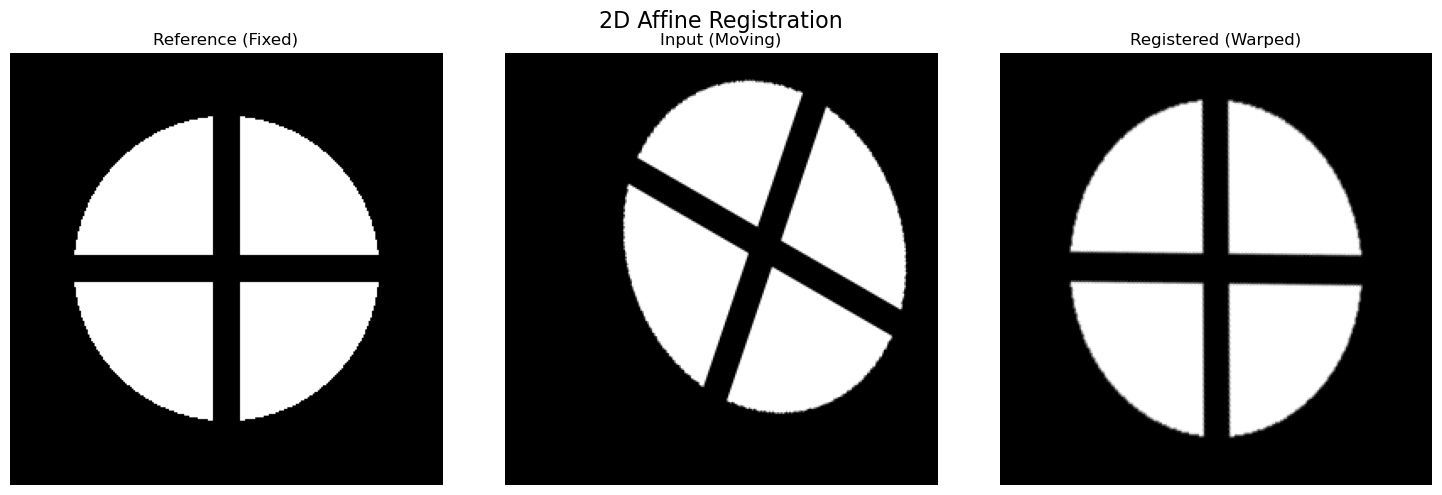

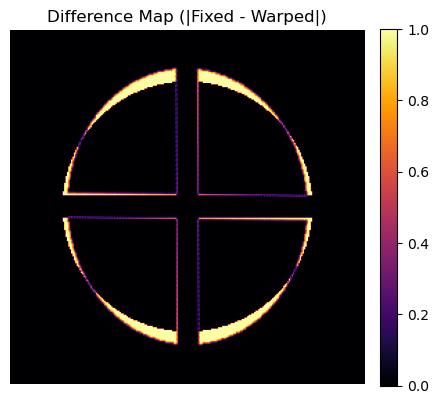

In [2]:
# --- 1. Generate Synthetic Data ---
N = 256
x, y = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
# Create a phantom: A circle with a cross inside
phantom = (x**2 + y**2 < 0.5).astype(np.float32)
phantom[120:136, :] = 0
phantom[:, 120:136] = 0

# --- 2. Create the "Moving" Image (Distorted) ---
# We use reg_torch itself to create the ground truth distortion!
# Let's apply: Rotation=30 deg, Translation=(0.2, -0.1), Shear=0.2
gt_params = {
    'theta': torch.tensor(np.radians(30.0)),
    'tx': torch.tensor(0.2),
    'ty': torch.tensor(-0.1), 
    'sx': torch.tensor(1.0), 'sy': torch.tensor(1.0),
    'shx': torch.tensor(0.2), 'shy': torch.tensor(0.0)
}

# Build matrix and warp
M_gt = reg.build_affine_matrix(**gt_params, device=device, dtype=torch.float32)
im_fixed = torch.from_numpy(phantom).unsqueeze(0).unsqueeze(0).to(device)
grid = torch.nn.functional.affine_grid(M_gt, im_fixed.shape, align_corners=False)
im_moving_tensor = torch.nn.functional.grid_sample(im_fixed, grid, align_corners=False)

# Convert back to numpy for input
ref_np = phantom
mov_np = im_moving_tensor.squeeze().cpu().numpy()

print("Data Generated. Running Registration...")

# --- 3. Run Optimization ---
warped_np, params = reg.register_affine_2d(
    ref=ref_np,
    mov=mov_np,
    order=['rot', 'trans', 'shear'], # We know there is no scaling, so we lock it
    loss_type='ncc',                 # NCC is robust to brightness, though MSE works here too
    iters=500,
    lr=0.02,
    verbose=True
)

# --- 4. Visualize ---
print(f"\nRecovered Params: \n Theta: {np.degrees(params['theta']):.2f}° (GT: 30°)")
print(f" Trans: ({params['tx']:.3f}, {params['ty']:.3f}) (GT: 0.2, -0.1)")
print(f" Shear X: {params['shx']:.3f} (GT: 0.2)")

plot_results(ref_np, mov_np, warped_np, title="2D Affine Registration")

## **2. 3D Volumetric Registration**

Registration in 3D is computationally expensive. By using PyTorch and CUDA, we can align volumes in seconds.
Here, we create a 3D block and apply a 3D rotation (Euler angles) and translation.

Optimizing 3D Alignment...


  3%|▎         | 6/200 [00:00<00:03, 55.17it/s]

[1/200] Loss=0.02779


 34%|███▍      | 68/200 [00:00<00:00, 154.93it/s]

[41/200] Loss=0.00150


 52%|█████▏    | 104/200 [00:00<00:00, 166.99it/s]

[81/200] Loss=0.00082


 70%|███████   | 140/200 [00:00<00:00, 169.65it/s]

[121/200] Loss=0.00082


 90%|█████████ | 181/200 [00:01<00:00, 177.26it/s]

[161/200] Loss=0.00082


100%|██████████| 200/200 [00:01<00:00, 158.55it/s]


[200/200] Loss=0.00082


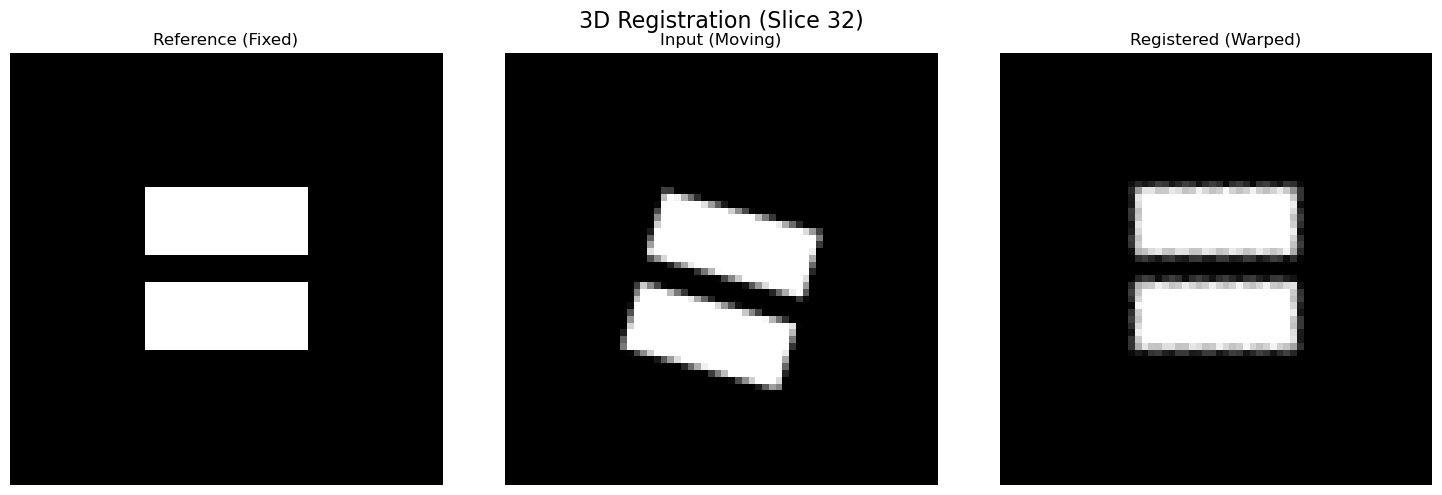

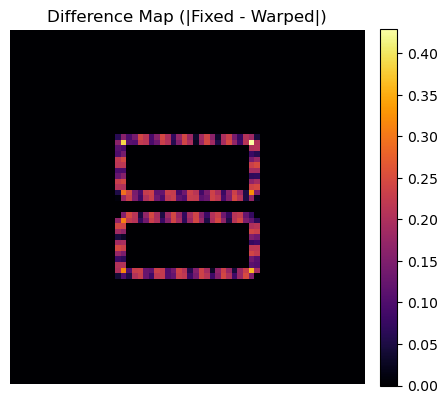

Recovered Z-Rotation: -14.91° (GT: 15.0°)
Recovered Y-Translation: -0.097 (GT: 0.1)


In [3]:
# --- 1. Generate 3D Data ---
D, H, W = 64, 64, 64
vol_ref = np.zeros((D, H, W), dtype=np.float32)
# Create a cube in the center
vol_ref[20:44, 20:44, 20:44] = 1.0 
# Add a "hole" to make rotation observable
vol_ref[20:44, 30:34, 20:44] = 0.0 

# Apply artificial 3D distortion
# Rotate around Z by 15 degrees, shift Y by 0.1
gt_3d = {
    'rx': torch.tensor(0.0), 'ry': torch.tensor(0.0), 'rz': torch.tensor(np.radians(15.0)),
    'tx': torch.tensor(0.0), 'ty': torch.tensor(0.1), 'tz': torch.tensor(0.0),
    'sx': torch.tensor(1.0), 'sy': torch.tensor(1.0), 'sz': torch.tensor(1.0)
}

M_3d = reg.build_affine_matrix_3d(**gt_3d, device=device, dtype=torch.float32)
v_fixed = torch.from_numpy(vol_ref).unsqueeze(0).unsqueeze(0).to(device)
grid_3d = torch.nn.functional.affine_grid(M_3d, v_fixed.shape, align_corners=False)
v_mov = torch.nn.functional.grid_sample(v_fixed, grid_3d, align_corners=False)

vol_mov = v_mov.squeeze().cpu().numpy()

# --- 2. Run 3D Registration ---
print("Optimizing 3D Alignment...")
warped_vol, params_3d = reg.register_affine_3d(
    vol_ref,
    vol_mov,
    order=['rot', 'trans'], # Optimize Rotation and Translation
    loss_type='mse',
    iters=200,
    lr=0.01,
    verbose=True
)

# --- 3. Visualization (Central Slice) ---
idx = D // 2
plot_results(vol_ref[idx], vol_mov[idx], warped_vol[idx], title=f"3D Registration (Slice {idx})")

print(f"Recovered Z-Rotation: {np.degrees(params_3d['rz']):.2f}° (GT: 15.0°)")
print(f"Recovered Y-Translation: {params_3d['ty']:.3f} (GT: 0.1)")

## **3. Batched Volume Warping**

In X-ray tomography, we often calculate a shift or rotation on a single projection or slice and want to apply it to the entire stack efficiently. 
`warp_volume_xy_batched` handles this by applying a 2D matrix to every slice in a 3D volume, processing them in chunks to manage memory.

Applying pixel shift (20, 25) to stack of shape (50, 256, 256)...


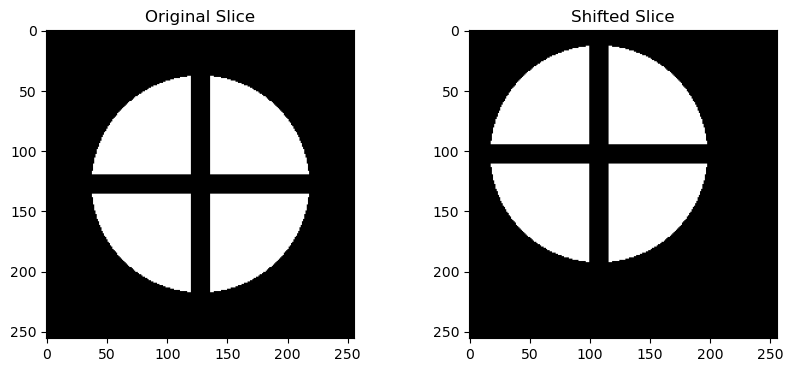

In [5]:
# Create a stack of identical images
stack_ref = np.repeat(ref_np[np.newaxis, :, :], 50, axis=0) # 50 slices

# Define a transformation matrix (Pixel space, like from Skimage/PyStackReg)
# Let's say we detected a shift of 10 pixels right and 5 pixels down
shift_x_pixels = 20
shift_y_pixels = 25
H, W = stack_ref.shape[1:]

# Pixel space affine matrix (3x3)
affine_pixel = np.array([
    [1, 0, shift_x_pixels],
    [0, 1, shift_y_pixels],
    [0, 0, 1]
])

print(f"Applying pixel shift ({shift_x_pixels}, {shift_y_pixels}) to stack of shape {stack_ref.shape}...")

# Apply to whole stack
warped_stack = reg.warp_volume_xy_batched(
    stack_ref, 
    affine_matrix=affine_pixel, 
    is_pixel_space=True, # Important: Tell function this is NOT normalized [-1, 1]
    batch_size=16, 
    device=device
)

# Check result on one slice
plt.figure(figsize=(10, 4))
plt.subplot(121); plt.imshow(stack_ref[0], cmap='gray'); plt.title("Original Slice")
plt.subplot(122); plt.imshow(warped_stack[0], cmap='gray'); plt.title("Shifted Slice")
plt.show()

## **4. Point Cloud Registration (ICP)**

Sometimes we deal with geometric data (coordinates) rather than pixel grids. `icp_torch` performs rigid registration on point clouds.

We will generate a random point cloud, rotate and translate it, and then recover the alignment.

Running ICP...


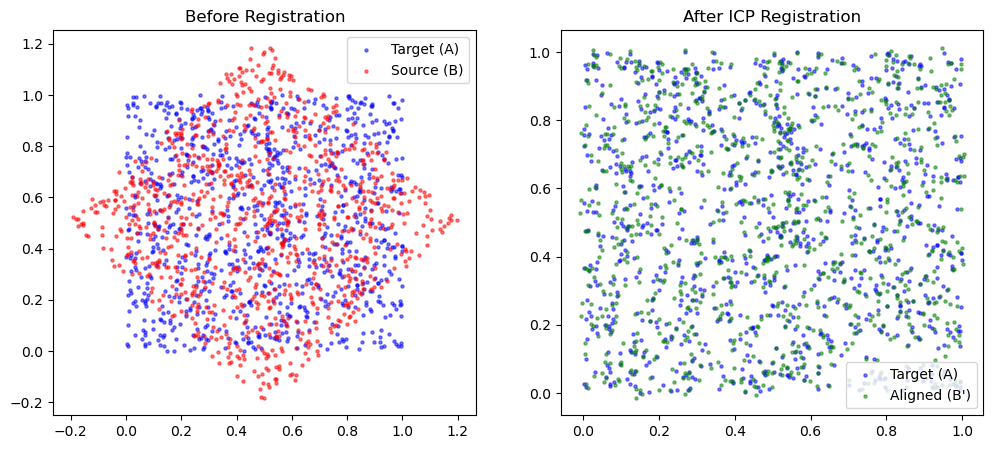

Rotation Error (Frobenius): 2.0039074915494455
Translation Error: 1.0164983104253222


In [ ]:

# --- 1. Generate Point Clouds ---
num_points = 1000
# Source points (Model)
A = np.random.rand(num_points, 3).astype(np.float32)

# Create Target points (Data) by applying rigid transform
theta = np.radians(45)
R_gt = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0, 0, 1]
])
t_gt = np.array([0.5, -0.2, 0.1])

# B = A * R^T + t
B = A @ R_gt.T + t_gt

# Add some noise
B += np.random.normal(0, 0.01, B.shape)

# --- 2. Run ICP ---
print("Running ICP...")
B_aligned, R_est, t_est = reg.icp_torch(
    A, B, 
    max_iterations=1000, 
    lr=0.01, 
    verbose=False
)

# --- 3. Visualization ---
# Project to 2D for plotting
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(A[:,0], A[:,1], s=5, c='blue', alpha=0.5, label='Target (A)')
plt.scatter(B[:,0], B[:,1], s=5, c='red', alpha=0.5, label='Source (B)')
plt.title("Before Registration")
plt.legend()

plt.subplot(122)
plt.scatter(A[:,0], A[:,1], s=5, c='blue', alpha=0.5, label='Target (A)')
plt.scatter(B_aligned[:,0], B_aligned[:,1], s=5, c='green', alpha=0.5, label='Aligned (B\')')
plt.title("After ICP Registration")
plt.legend()

plt.show()

print("Rotation Error (Frobenius):", np.linalg.norm(R_gt - R_est))
print("Translation Error:", np.linalg.norm(t_gt - t_est))

# Conclusion

## **Summary of Key Takeaways**

In this tutorial, we demonstrated how the **`reg_torch`** module provides a powerful, functional interface for geometric transformations and alignment within the **nDTomo** framework.

Key highlights include:
- **Differentiable Alignment:** By using PyTorch's `grid_sample` and `affine_grid`, we can treat geometric parameters (rotation, translation, shear) as learnable weights, optimizing them via gradient descent rather than traditional search methods.
- **Unified 2D & 3D Support:** The library seamlessly handles both 2D image registration and 3D volumetric alignment using a consistent API.
- **Batch Processing:** We showed how to apply transformations efficiently to large stacks of data (e.g., laminography or tomography projections) using batched operations, essential for high-throughput pipelines.
- **GPU Acceleration:** All operations run natively on CUDA devices, enabling real-time performance even for complex 3D optimizations.

## **🚀 What You Can Do Next:**
- **Motion Correction in Tomography:** Integrate `register_affine_2d` into a reconstruction loop to correct for sample drift or vibrations in experimental data before backprojection.
- **Multimodal Registration:** Use the `ncc_loss` (Normalized Cross Correlation) to align data from different modalities (e.g., X-ray fluorescence vs. diffraction contrast) where intensities may not be directly comparable.

> Just like the reconstruction modules, these registration tools are designed to be modular and functional, empowering you to build custom, high-performance imaging pipelines without getting bogged down in complex class hierarchies.

This notebook serves as a foundation for building robust, motion-aware imaging workflows in **nDTomo**.